In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dense_model, get_simple_dist_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import (model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, 
                  save_object, load_object)
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
model_dir = 'models/uncertainty/experiment/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Distribution layer performance

In [42]:
def get_nodes_list(mode, size):
    if mode == "dense":
        if size == "small":
            return [2, 4, 8, 16, 32, 64, 128]
        else:
            return [256, 512, 1024]
    if mode in ["dist2", "dist4", "direct"]:
        if size == "small":
            return [1, 2, 4, 6, 8, 16, 32]
        else:
            return [64, 128, 256]

**Run 1: small nodes of layers 'direct' and 'dist2'**

In [45]:
def transform_experiment_results(run_dir, layer_labels, size):
    ls = []

    for mode in layer_labels:
        m1, m2, m3 = [load_object(run_dir + mode + "_part{}_metrics.pickle".format(i))
                              for i in range(1, 1+3)]

        labels = ['part1', 'part2', 'part3']
        nodes_list = get_nodes_list(mode, size)

        for metrics, label in zip([m1, m2, m3], labels):
            for m, num_nodes in zip(metrics, np.tile(nodes_list, 9)):
                level = list(m.keys())[0]
                score = m['WSPL']
                ls += [[mode, level, num_nodes, label, score]]
    
    df = pd.DataFrame(ls, columns=['layer', 'level', 'nodes', 'part', 'WSPL'])
    return df

df1 = transform_experiment_results(model_dir + "run1_a/", ['direct', 'dist2'], "small")
df2 = transform_experiment_results(model_dir + "run2_a/", ['dist4', 'dense'], "small")
df3 = transform_experiment_results(model_dir + "run3_a/", ['direct', 'dist2', 'dist4', 'dense'], "medium")

In [49]:
results = pd.concat((df1, df2, df3))
results

,layer,level,nodes,part,WSPL
0,direct,1,1,part1,0.424447
1,direct,1,2,part1,0.421090
2,direct,1,4,part1,0.103095
3,direct,1,6,part1,0.080821
4,direct,1,8,part1,0.074454
...,...,...,...,...,...
319,dense,8,512,part3,0.167957
320,dense,8,1024,part3,0.182561
321,dense,9,256,part3,0.141018
322,dense,9,512,part3,0.147454


## Plot per level, per layer

direct


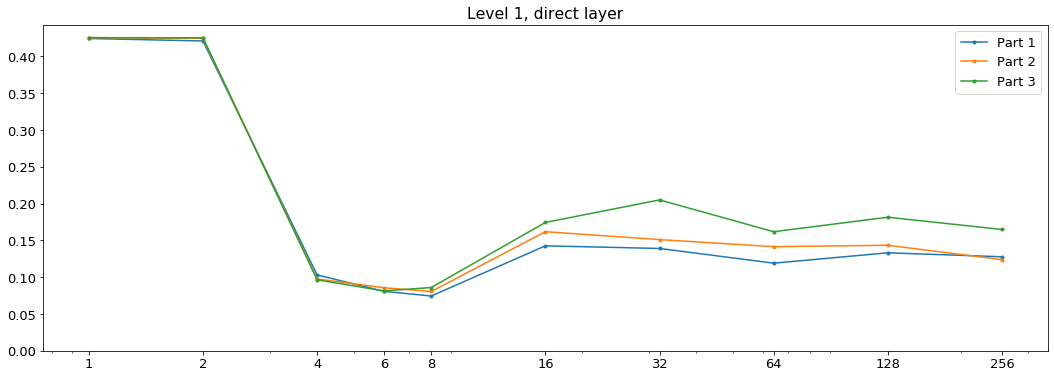

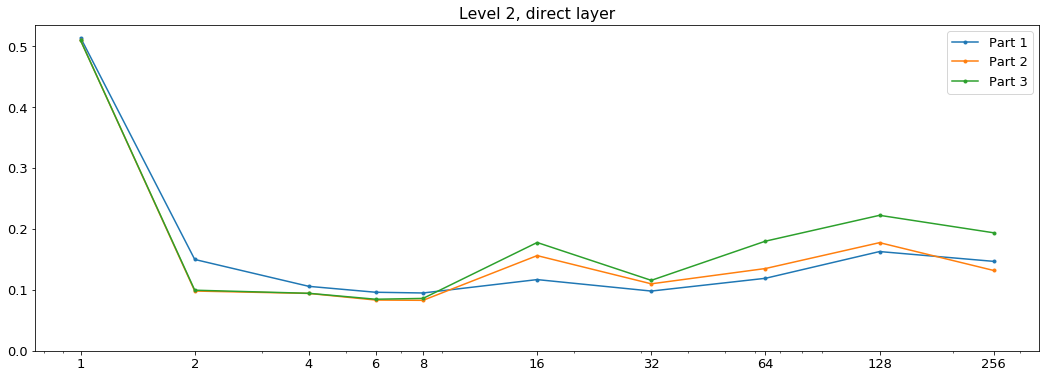

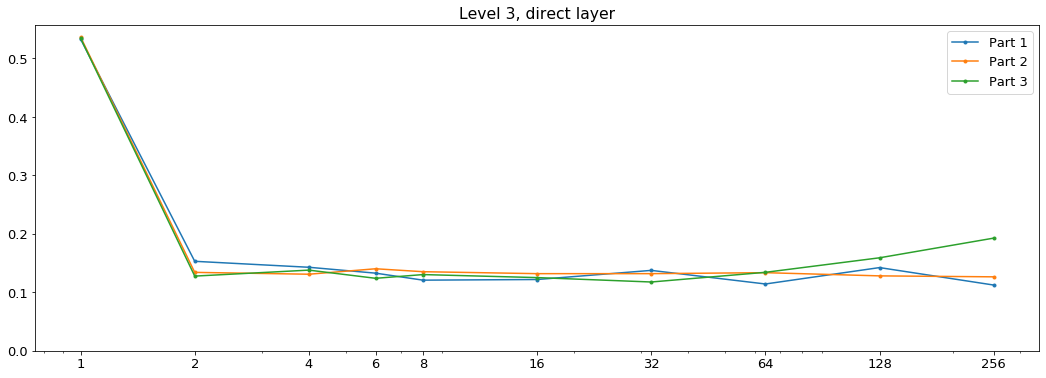

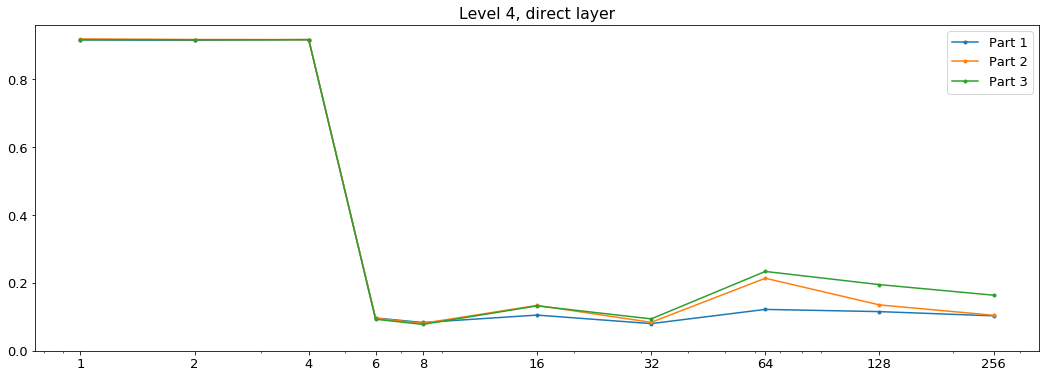

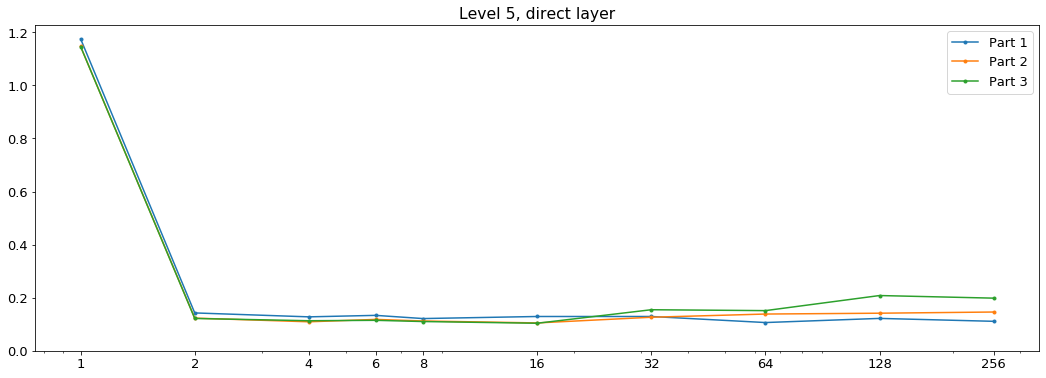

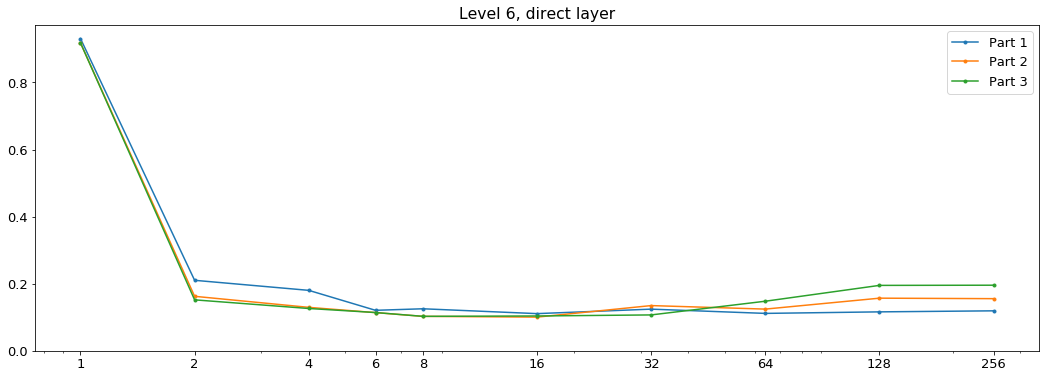

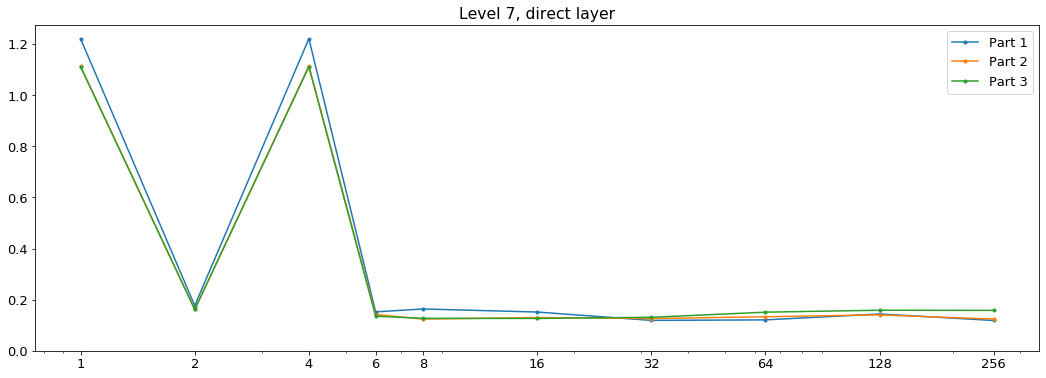

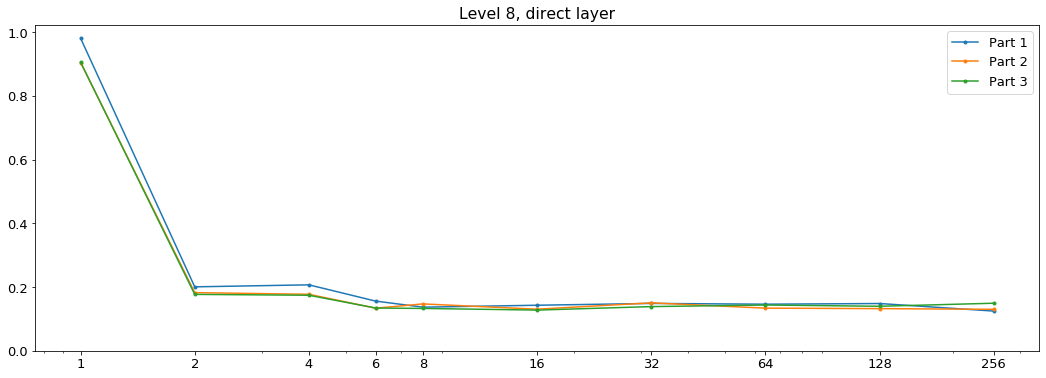

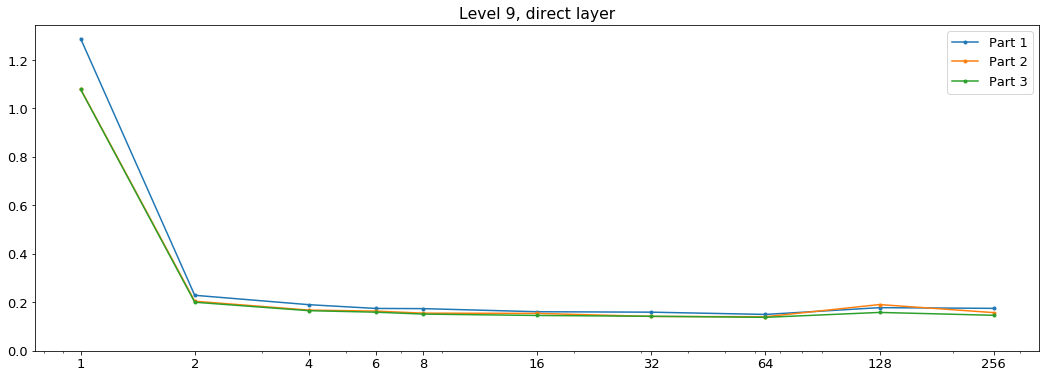

dist2


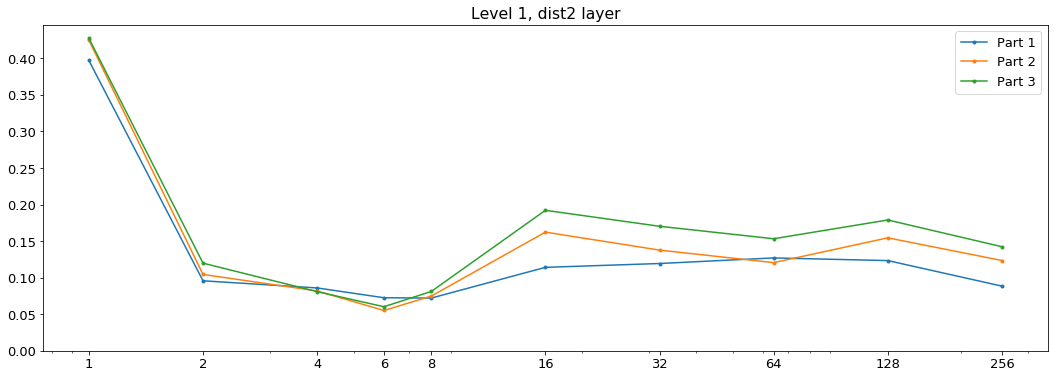

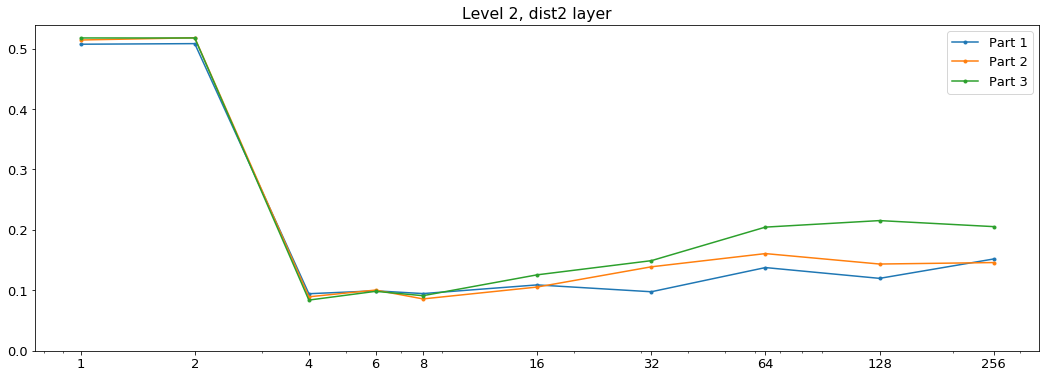

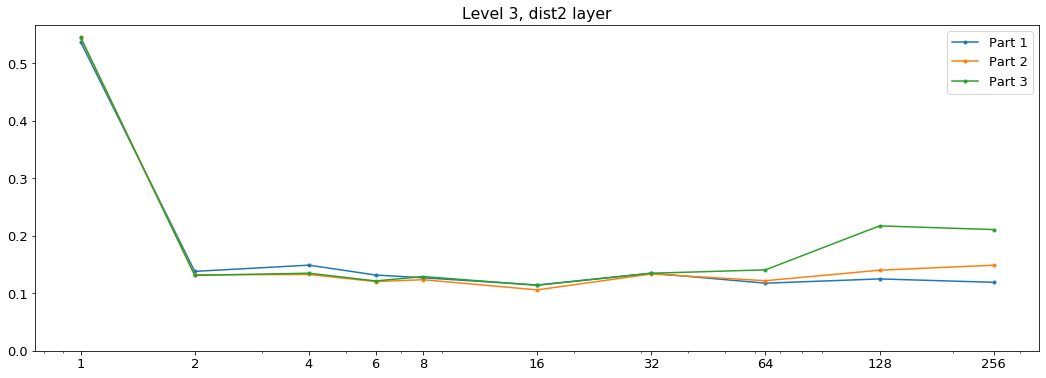

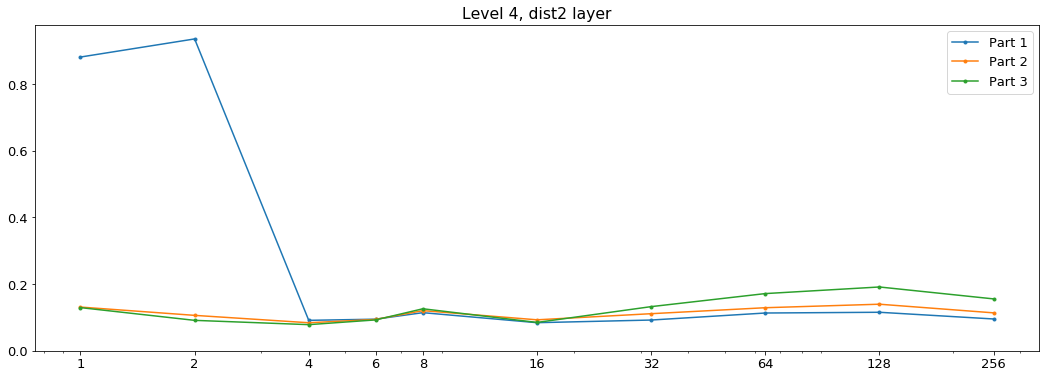

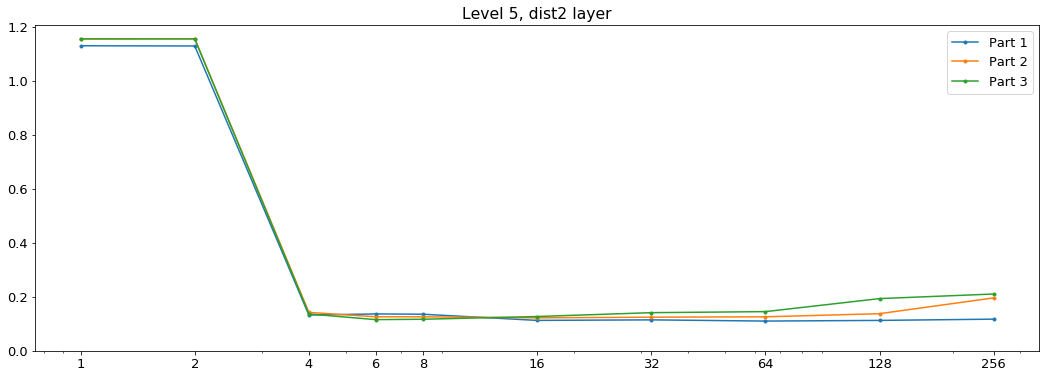

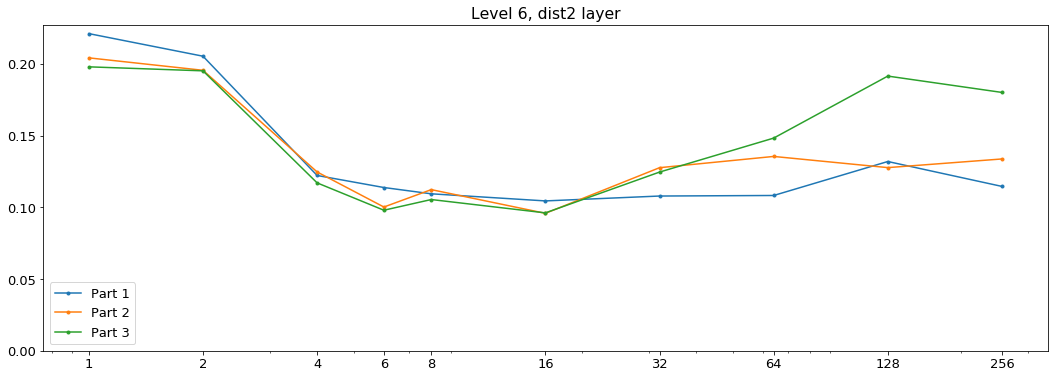

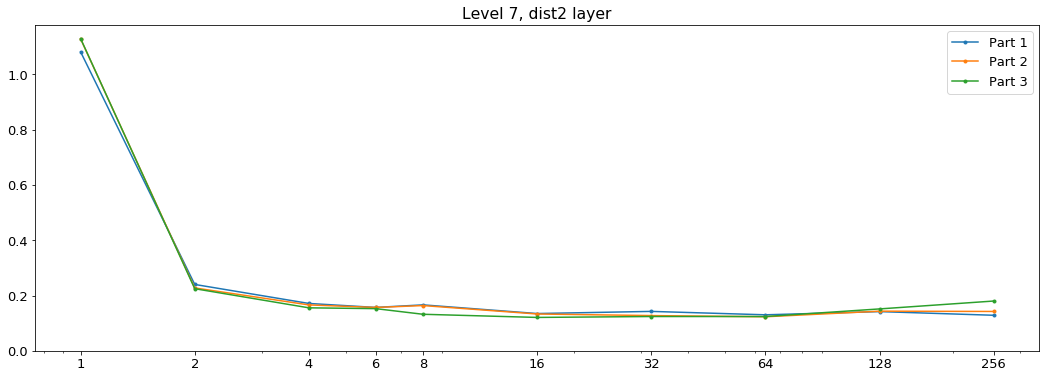

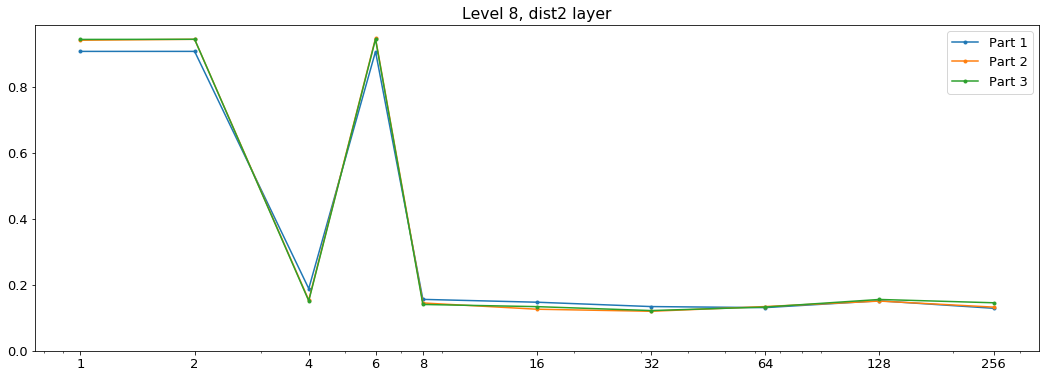

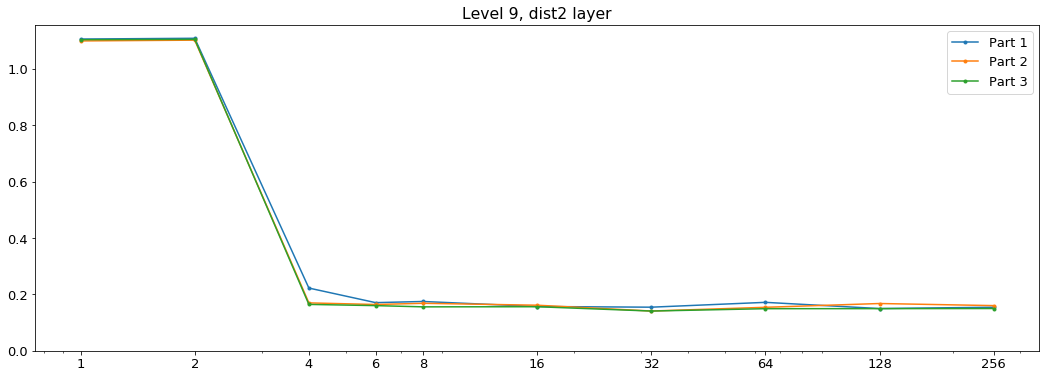

dist4


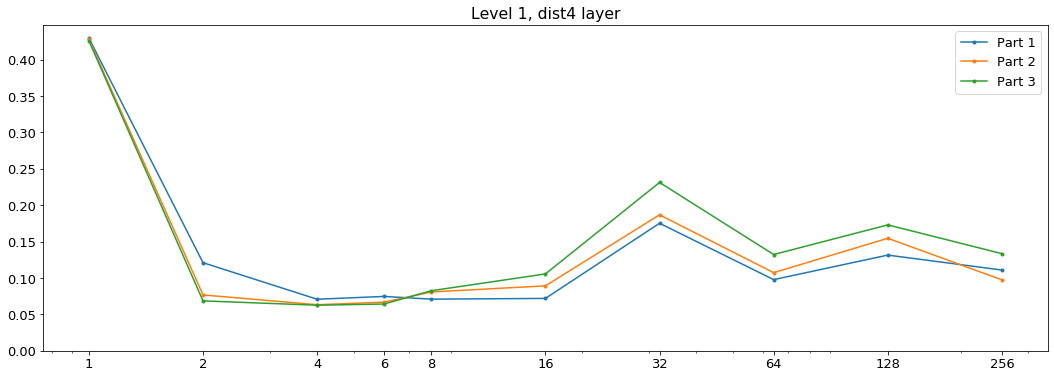

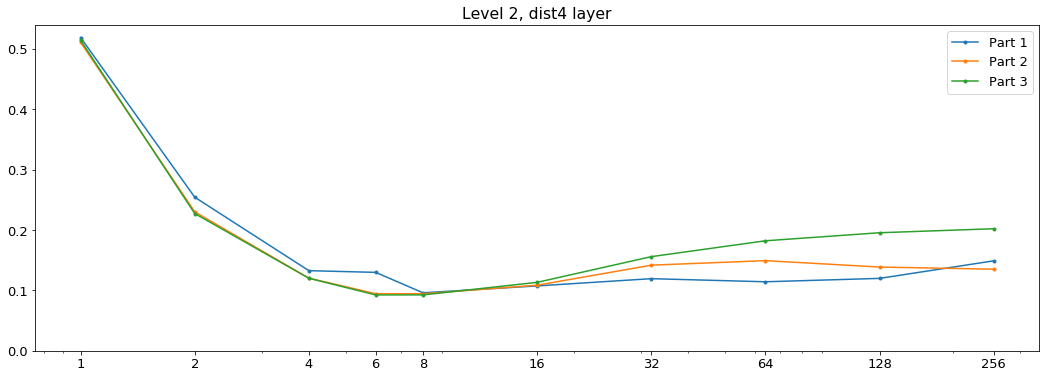

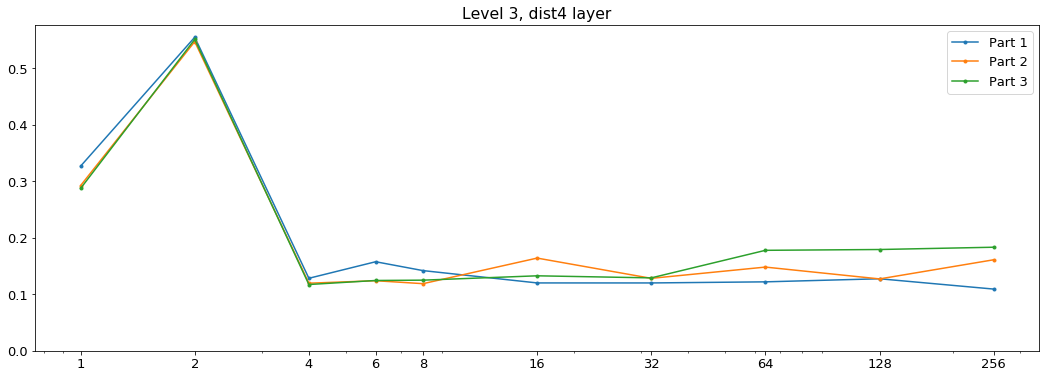

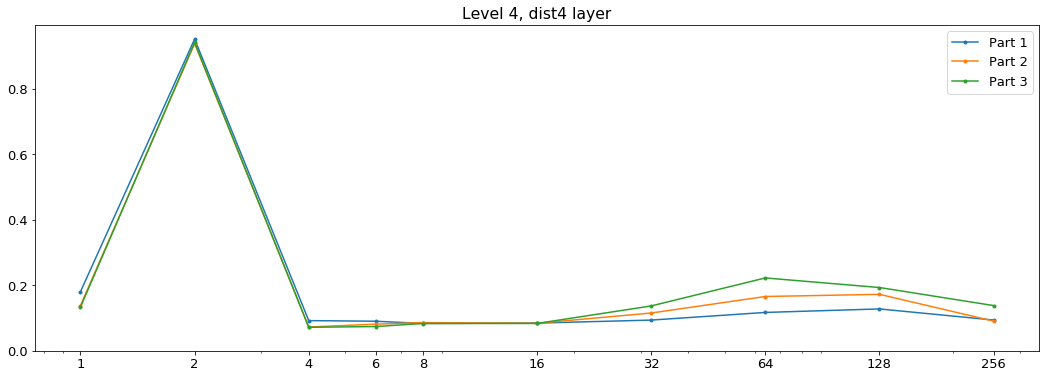

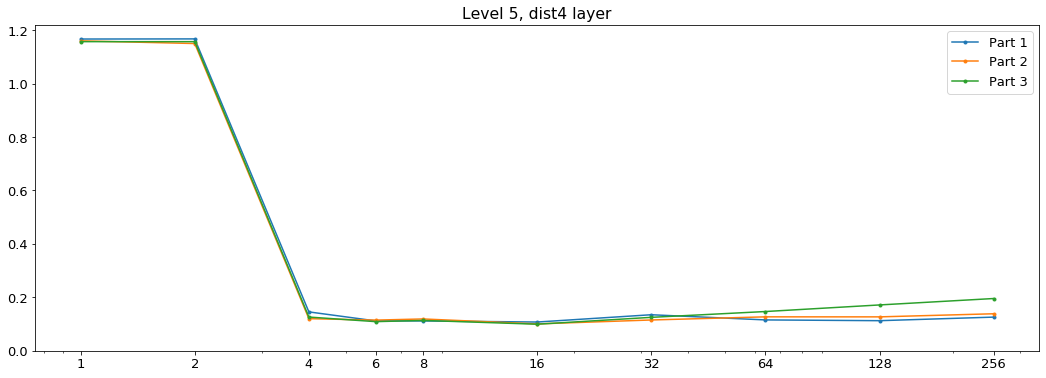

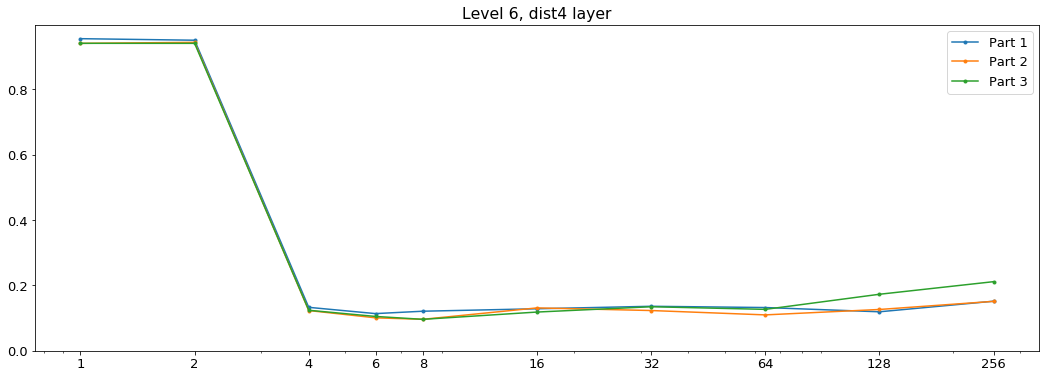

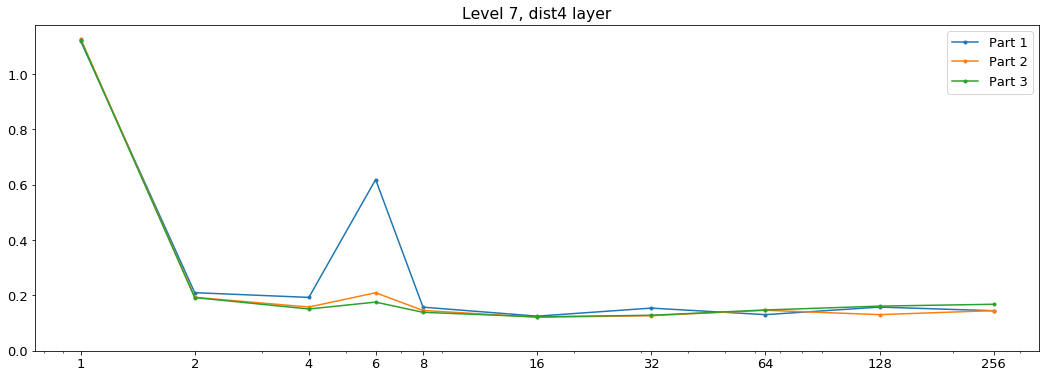

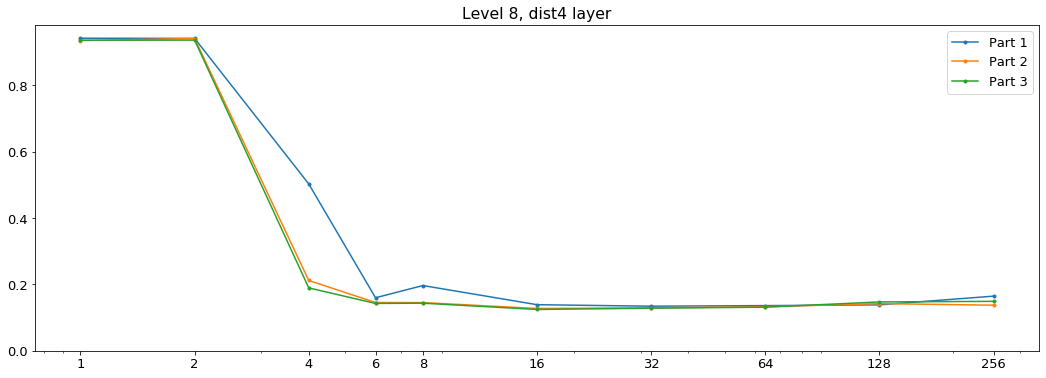

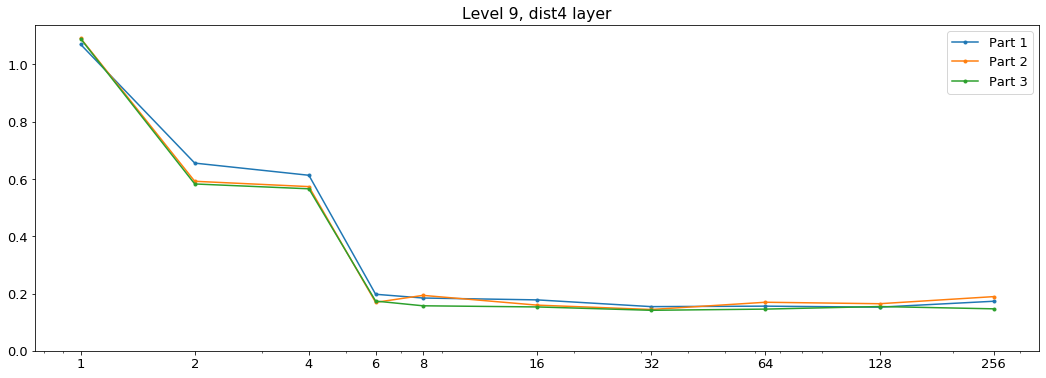

dense


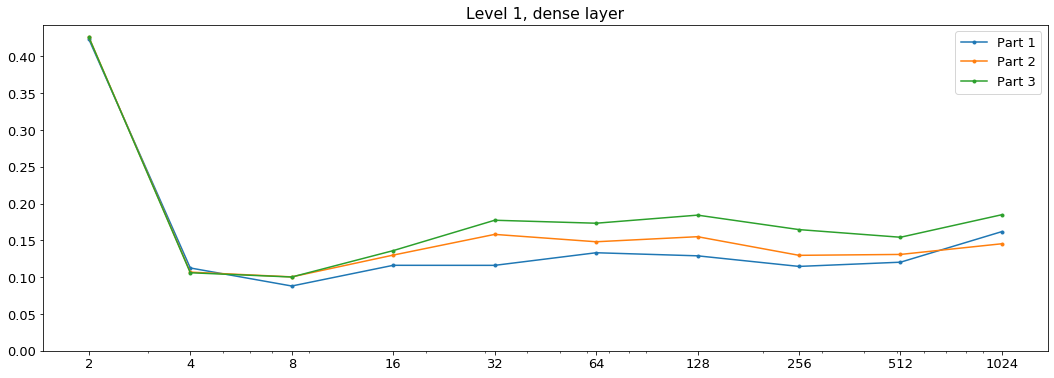

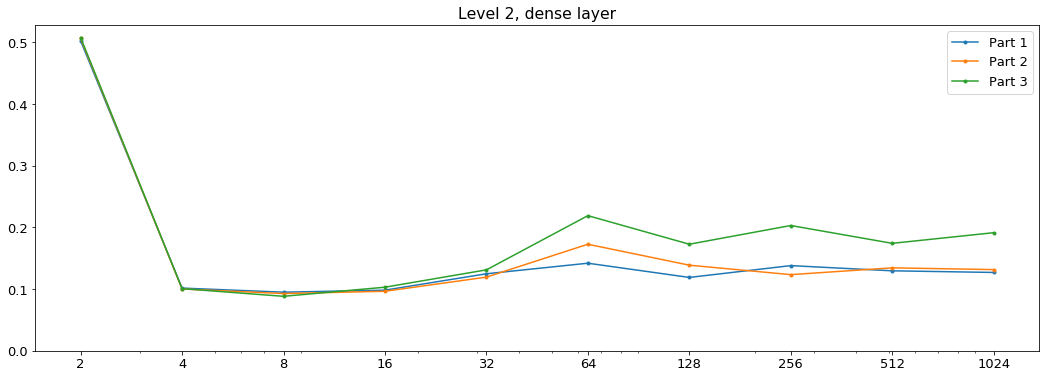

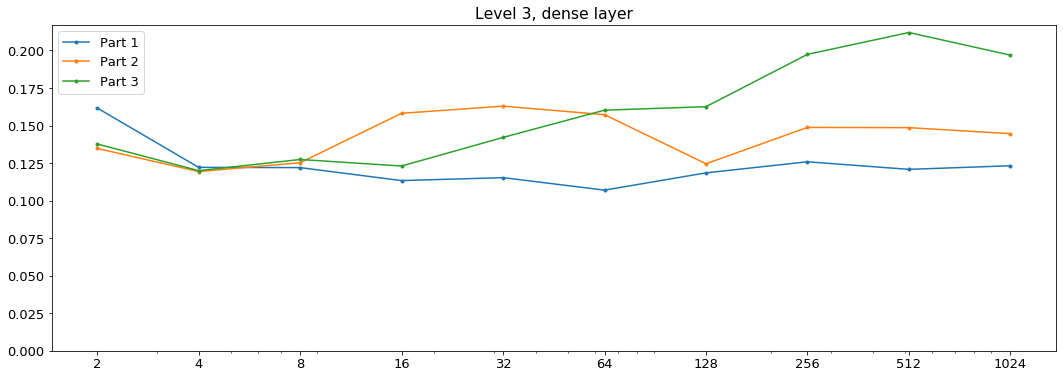

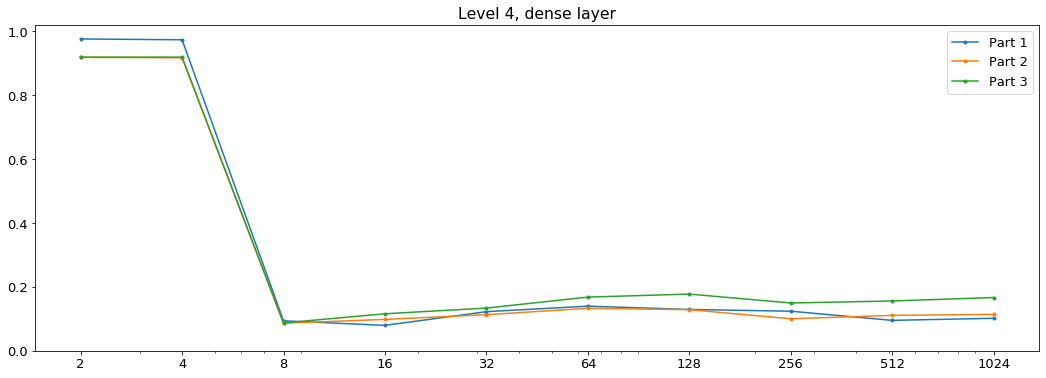

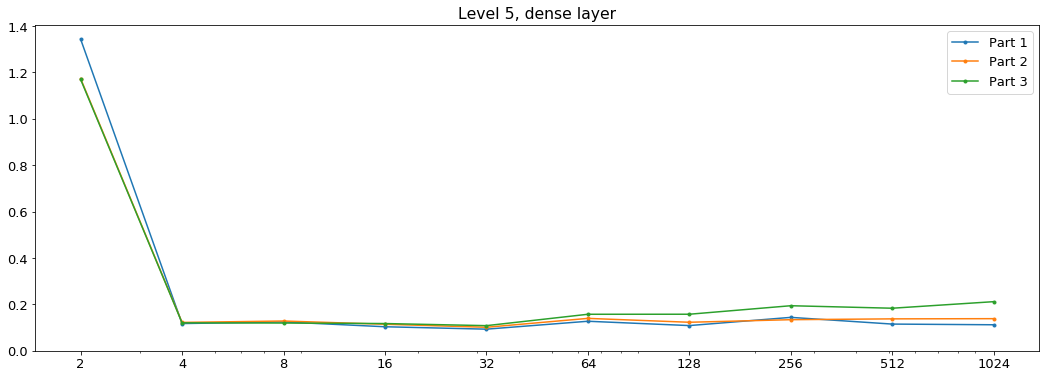

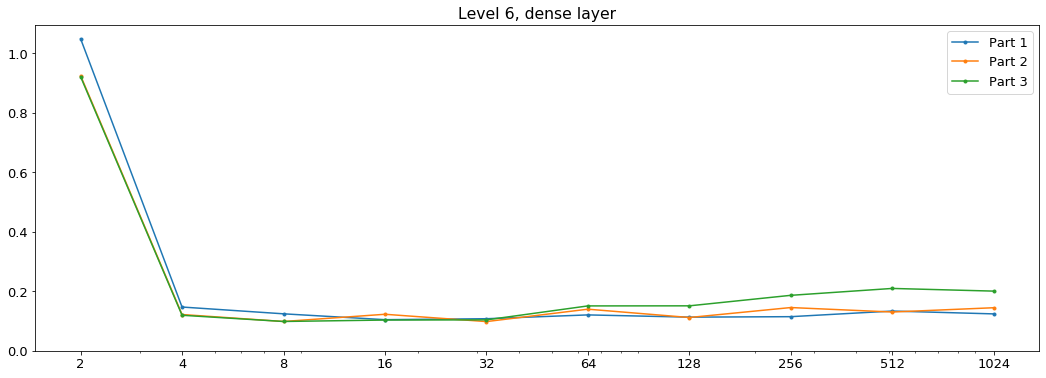

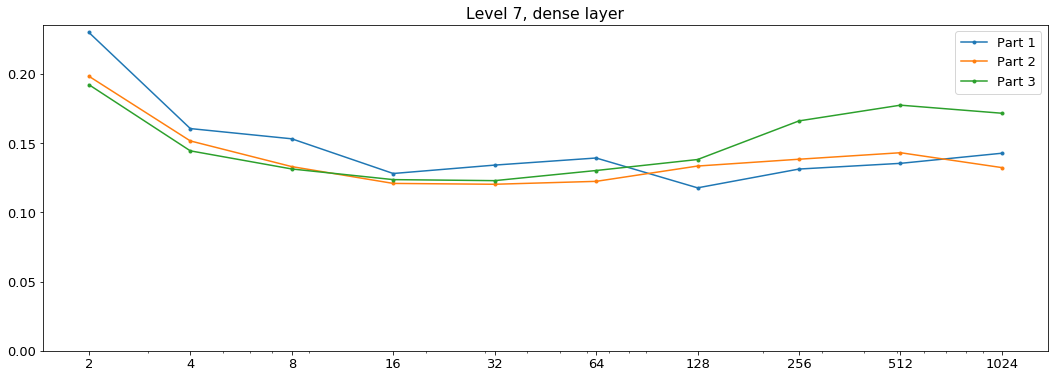

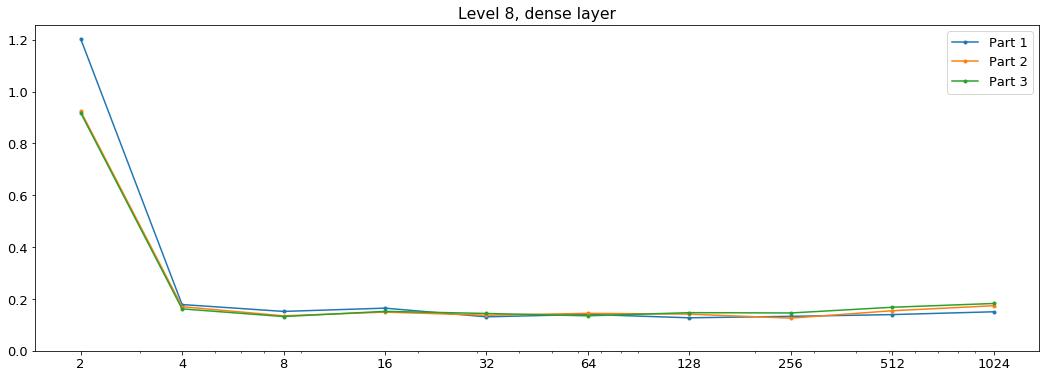

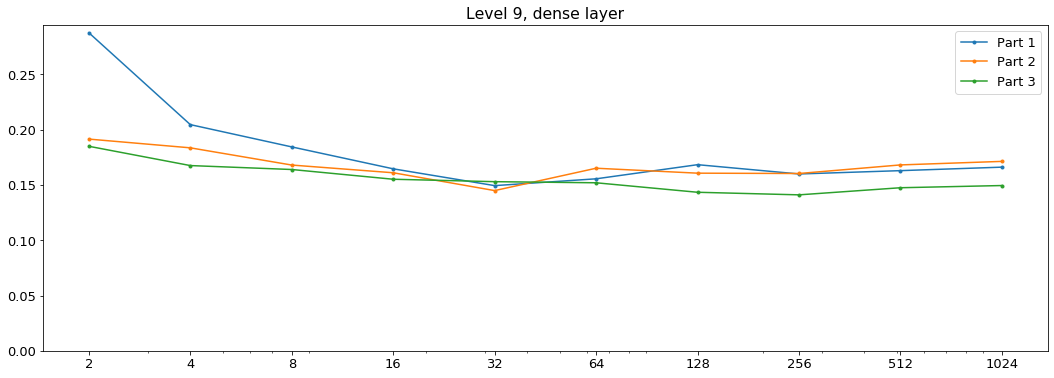

In [101]:
# plot performance for each layer, at each level
for layer in results.layer.unique():
    print(layer)
    
    df_layer = results[results.layer == layer]
    for level in df_layer.level.unique():
        df = df_layer[df_layer.level == level]
        
        f, ax = plt.subplots(1, 1, figsize=(18, 6))
        for i in range(1, 3+1):
            df_part = df[df.part == f'part{i}']
            ax.plot(df_part['nodes'], df_part['WSPL'], '.-', label=f'Part {i}')
        
        ax.set_ylim(0)
        ax.set_xscale('log')
        ax.set_xticks(df_part['nodes'].values)
        ax.set_xticklabels(df_part['nodes'].values)
        ax.set_title("Level {}, {} layer".format(level, layer))
        ax.legend()
        plt.show()

## Create table of best run, per level, per layer
For each level and each layer, select best WSPL

In [75]:
df = results.groupby(['level', 'layer'])['WSPL'].min()
df

level  layer 
1      dense     0.088031
       direct    0.074454
       dist2     0.055126
       dist4     0.062630
2      dense     0.088350
       direct    0.082794
       dist2     0.083923
       dist4     0.092523
3      dense     0.106994
       direct    0.112470
       dist2     0.105965
       dist4     0.109114
4      dense     0.079545
       direct    0.077743
       dist2     0.078448
       dist4     0.071642
5      dense     0.093289
       direct    0.103808
       dist2     0.110131
       dist4     0.099504
6      dense     0.098190
       direct    0.100415
       dist2     0.095824
       dist4     0.096236
7      dense     0.117629
       direct    0.118617
       dist2     0.120707
       dist4     0.121149
8      dense     0.125954
       direct    0.124689
       dist2     0.119655
       dist4     0.124606
9      dense     0.141018
       direct    0.138119
       dist2     0.140975
       dist4     0.141423
Name: WSPL, dtype: float64

In [81]:
df_table = df.unstack().T
df_table

level,1,2,3,4,5,6,7,8,9
layer,,,,,,,,,
dense,0.088031,0.088350,0.106994,0.079545,0.093289,0.098190,0.117629,0.125954,0.141018
direct,0.074454,0.082794,0.112470,0.077743,0.103808,0.100415,0.118617,0.124689,0.138119
dist2,0.055126,0.083923,0.105965,0.078448,0.110131,0.095824,0.120707,0.119655,0.140975
dist4,0.062630,0.092523,0.109114,0.071642,0.099504,0.096236,0.121149,0.124606,0.141423


In [84]:
print(df_table.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
level &         1 &         2 &         3 &         4 &         5 &         6 &         7 &         8 &         9 \\
layer  &           &           &           &           &           &           &           &           &           \\
\midrule
dense  &  0.088031 &  0.088350 &  0.106994 &  0.079545 &  0.093289 &  0.098190 &  0.117629 &  0.125954 &  0.141018 \\
direct &  0.074454 &  0.082794 &  0.112470 &  0.077743 &  0.103808 &  0.100415 &  0.118617 &  0.124689 &  0.138119 \\
dist2  &  0.055126 &  0.083923 &  0.105965 &  0.078448 &  0.110131 &  0.095824 &  0.120707 &  0.119655 &  0.140975 \\
dist4  &  0.062630 &  0.092523 &  0.109114 &  0.071642 &  0.099504 &  0.096236 &  0.121149 &  0.124606 &  0.141423 \\
\bottomrule
\end{tabular}



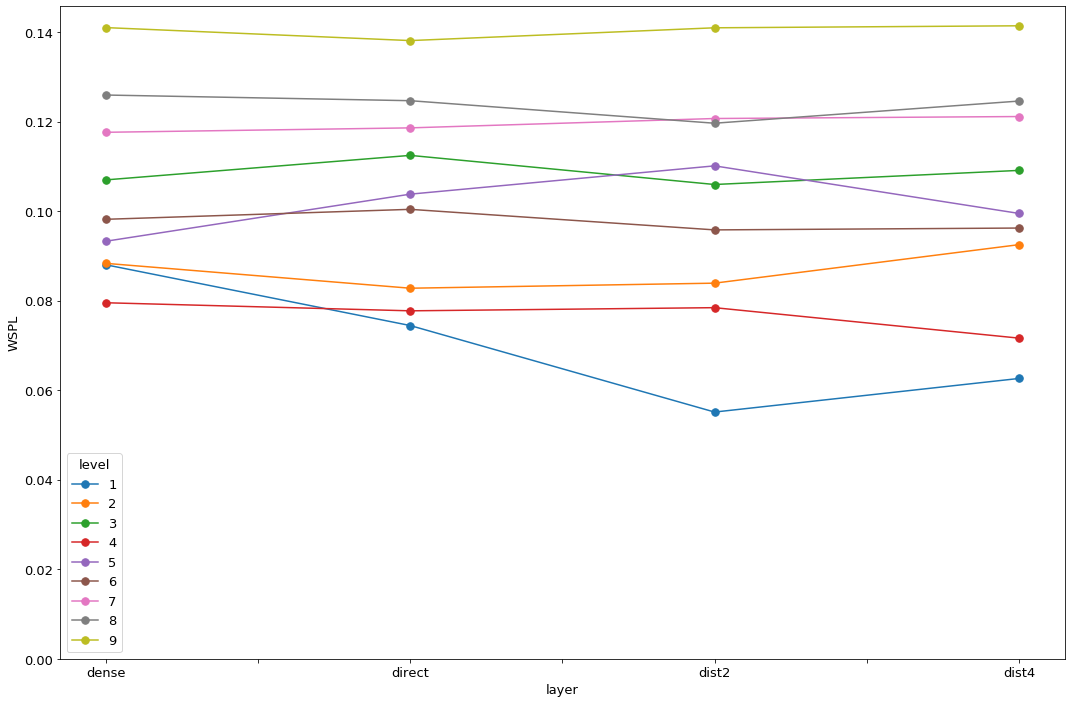

In [97]:
df_table.plot(marker='.', markersize=15, figsize=(18, 12))
plt.ylim(0)
plt.ylabel("WSPL")
plt.savefig("best_per_layer.pdf")
plt.show()

## Plot per level, part 3

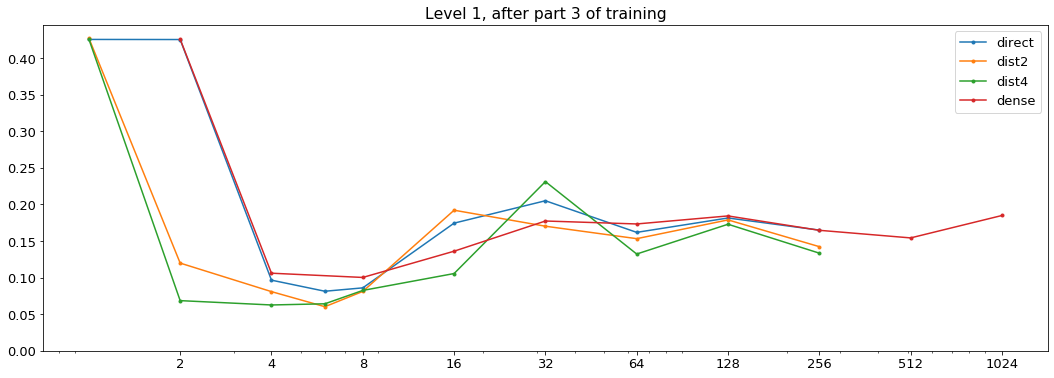

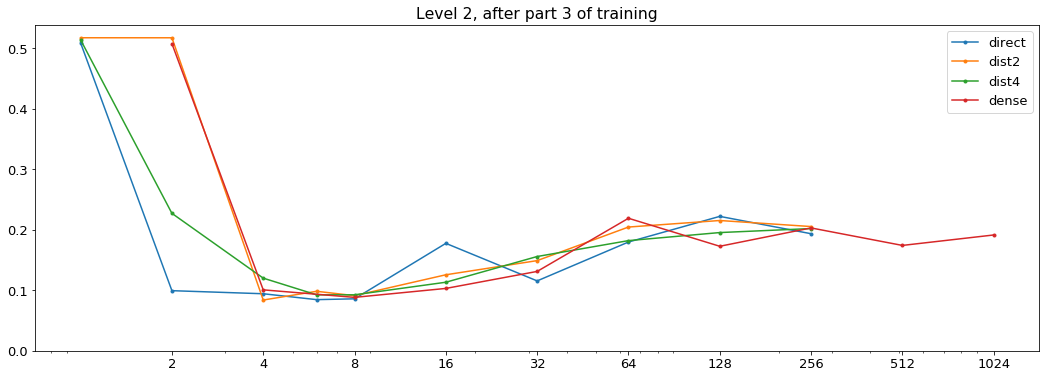

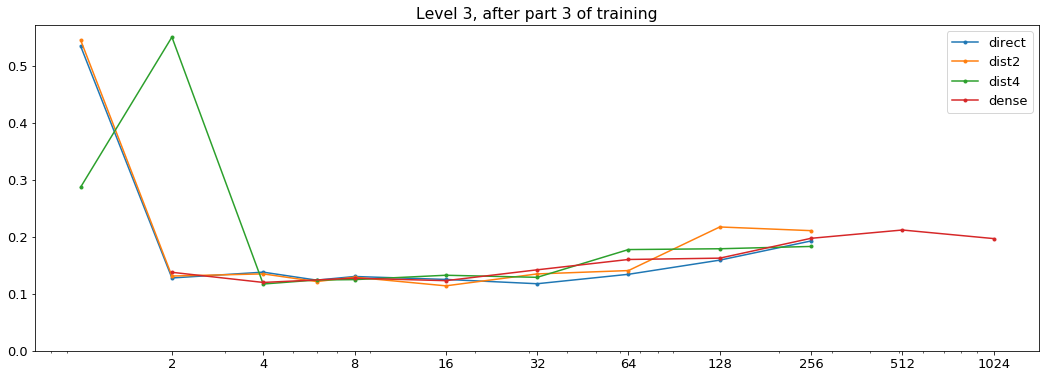

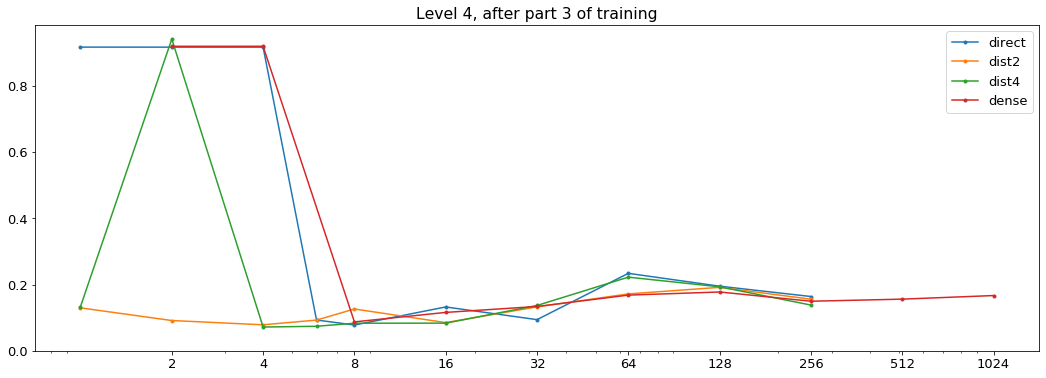

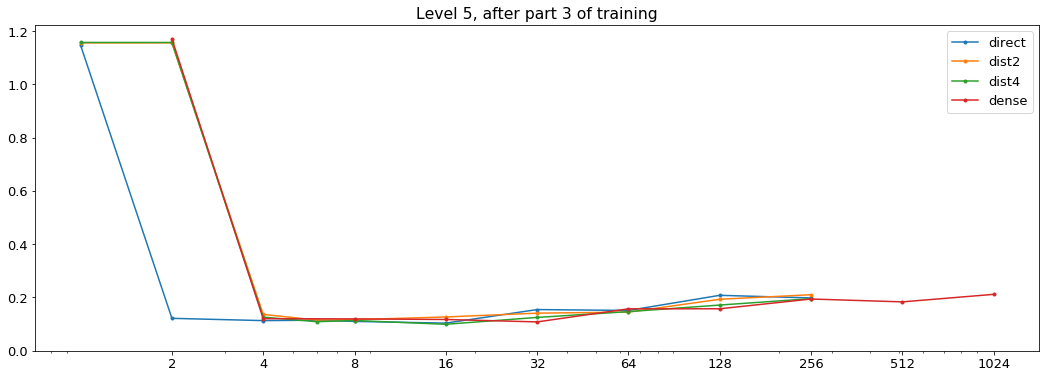

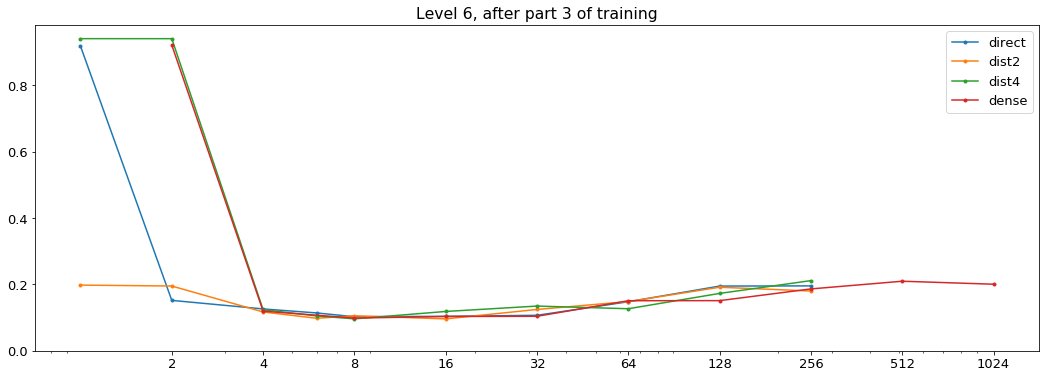

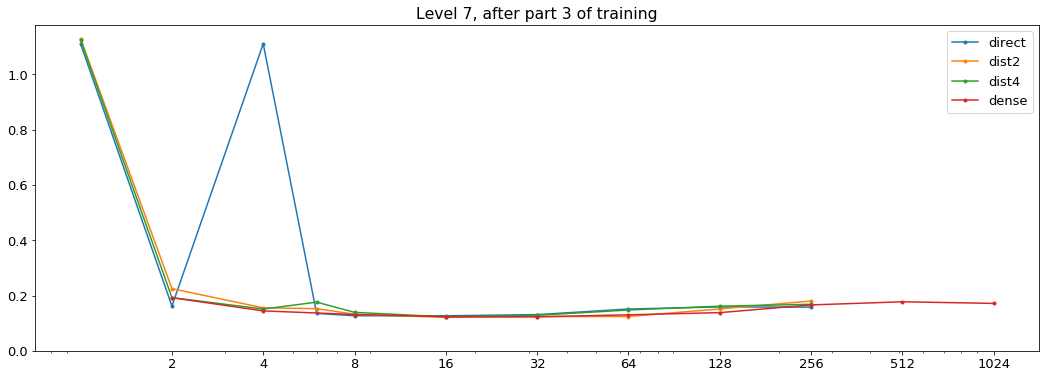

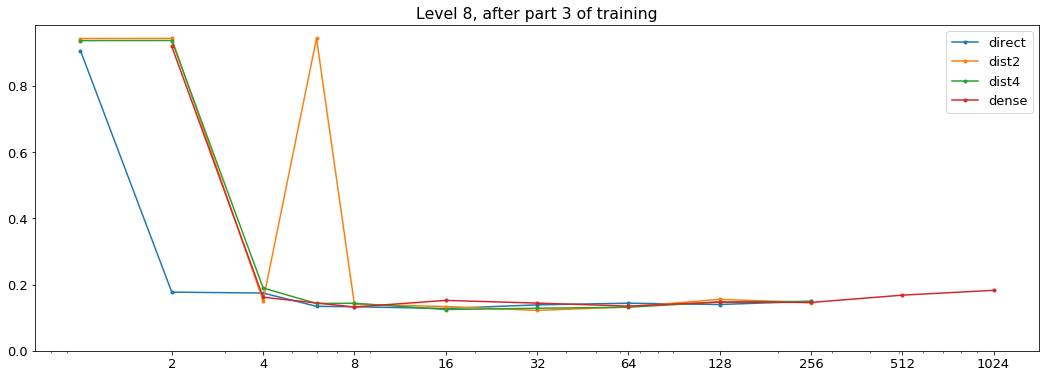

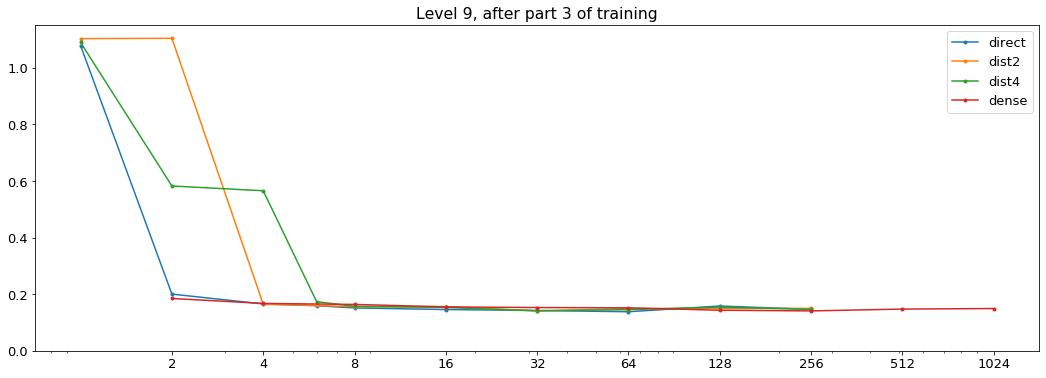

In [100]:
# plot performance for each level, after part 3
for level in results.level.unique():
    df = results[results.level == level]
    
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    for layer in results.layer.unique():
        df_layer = df[(df.layer == layer) & (df.part == f'part{i}')]
        ax.plot(df_layer['nodes'], df_layer['WSPL'], '.-', label=layer)
    
    ax.set_ylim(0)
    ax.set_xscale('log')
    ax.set_xticks(df_layer['nodes'].values)
    ax.set_xticklabels(df_layer['nodes'].values)
    ax.set_title("Level {}, after part 3 of training".format(level))
    ax.legend()
    plt.show()

### Zoom-in

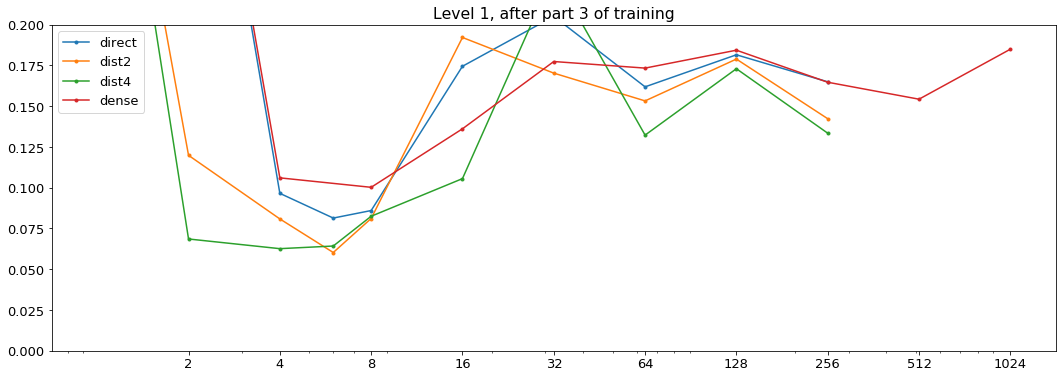

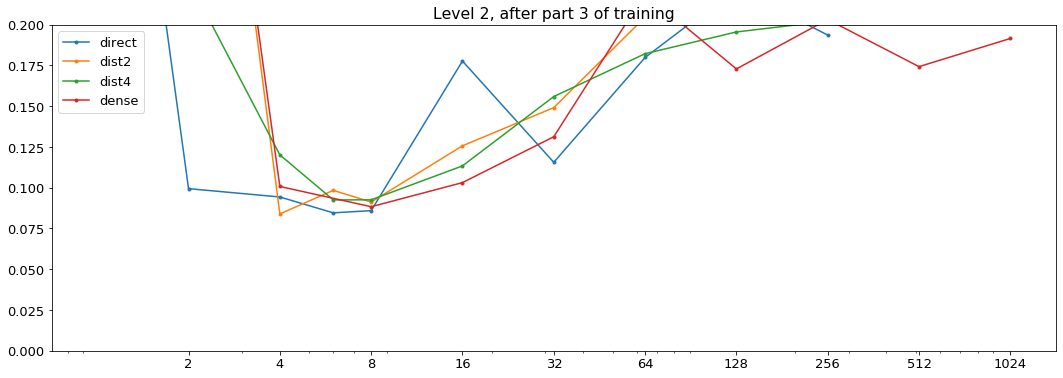

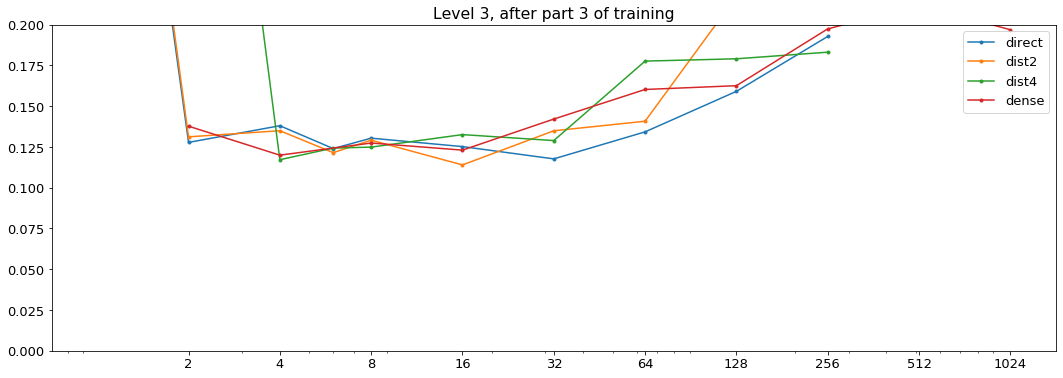

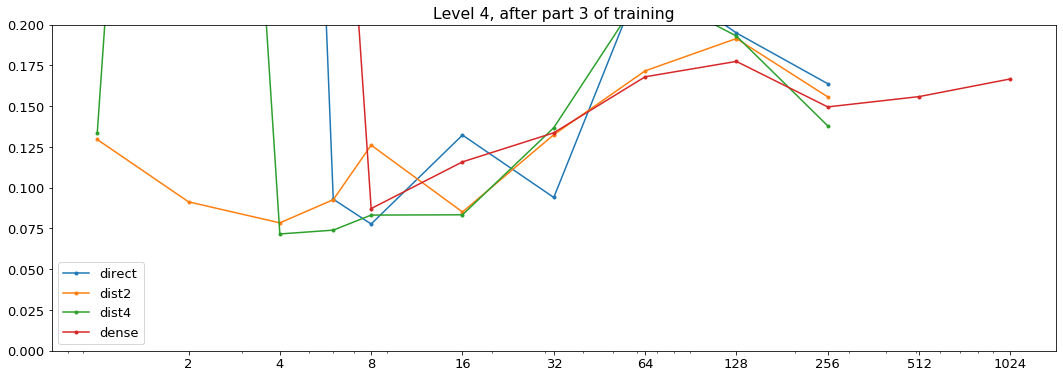

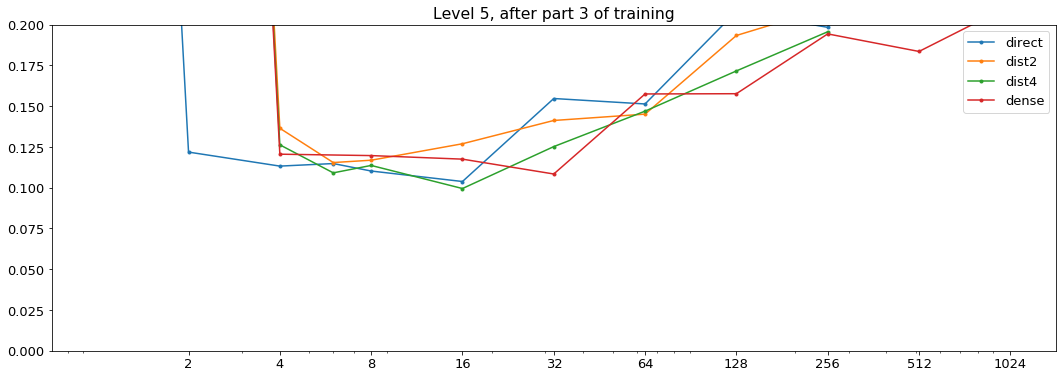

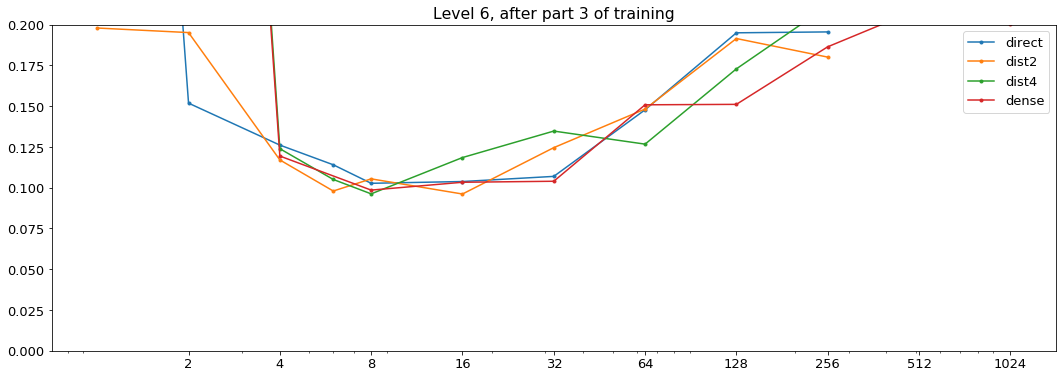

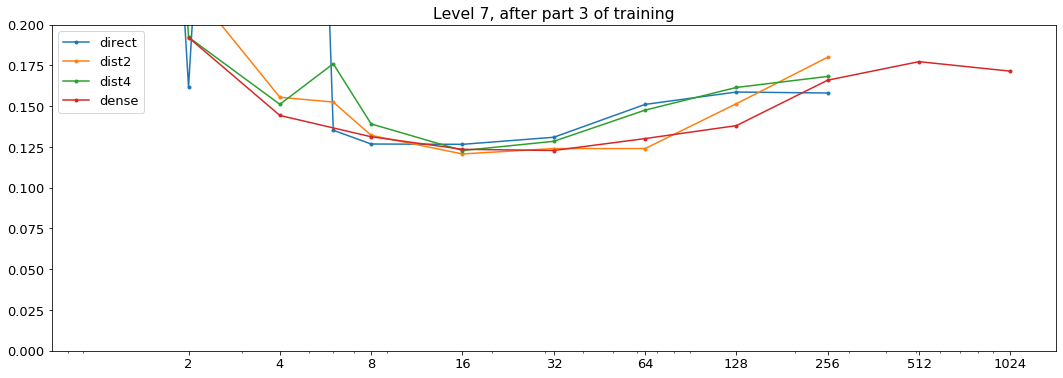

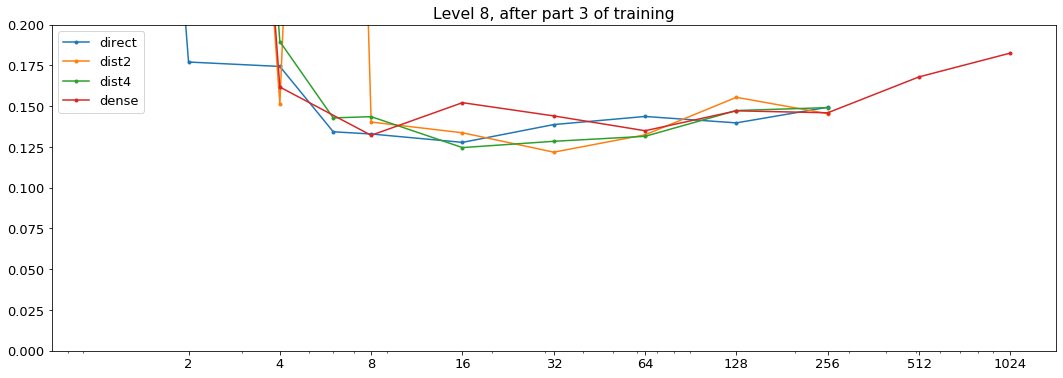

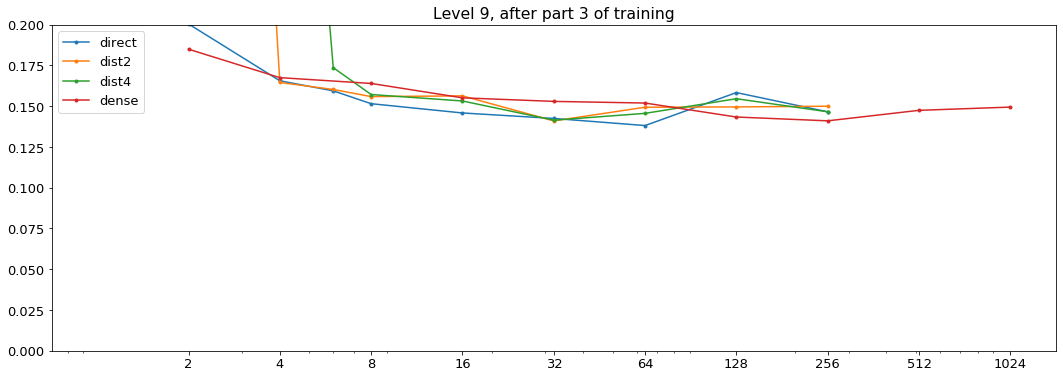

In [102]:
# plot performance for each level, after part 3
for level in results.level.unique():
    df = results[results.level == level]
    
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    for layer in results.layer.unique():
        df_layer = df[(df.layer == layer) & (df.part == f'part{i}')]
        ax.plot(df_layer['nodes'], df_layer['WSPL'], '.-', label=layer)
    
    ax.set_ylim(0, 0.2)
    ax.set_xscale('log')
    ax.set_xticks(df_layer['nodes'].values)
    ax.set_xticklabels(df_layer['nodes'].values)
    ax.set_title("Level {}, after part 3 of training".format(level))
    ax.legend()
    plt.show()